***NOTE**: This assignment uses the completed BooleanModeling.ipynb notebook from the practical as a starting point. The assignment starts after this part.*

Please follow the rules/instructions for making the assignments. This means, for every exercise:

- Make sure the code is **well-documented**
- Update the README file, found in the same directory as the assignment, this means:
    - Describe the objective of the assignment
    - Provide instructions on how to run your code
    - Include any other relevant notes or dependencies

Also, please be mindful of the rules for the use of Generative AI:
- You may use generative AI tools (e.g., ChatGPT, GitHub Copilot, etc.) in your assignments under the following conditions:
    - Clearly indicate where and how you used generative AI
    - Save and submit the AI conversation alongside your assignment (upload the transcript alongside your assignment)
    - Remember: Using AI tools should support your learning, not replace it. Make sure the work you submit reflects your group’s understanding. All group members are still responsible for understanding and being able to explain all submitted content.

# Boolean Networks - Computer Practical

Focus: Network dynamics, state spaces, and predictive modeling

## Instructions for Students
- 🟢 **Code**: Code provided - run and observe
- 🟡 **TODO**: You need to complete these - look for TODO comments
- ❓ **Question**: Analysis questions you need to answer


In [1]:
# 🟢 Setup and Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

### What are boolean networks?
Boolean networks are mathematical models where:
*   Each node has a binary state: ON (1) or OFF (0)
*   Nodes update based on Boolean rules (AND, OR, NOT)

### Why should you use Boolean Networks?
*   Handle discrete/categorical data naturally  
*   Model complex systems with simple rules
*   Find stable patterns (attractors) in data
*   Test 'what-if' scenarios (perturbation analysis)







---

### Helper functions to create a Boolean network
Run the following code snippet so the basic functions are available.

In [2]:
# 🟢 Helper class to build and simulate boolean network

class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()  # NetworkX graph for visualization

        # Add nodes to NetworkX graph
        self.graph.add_nodes_from(node_names)

    def add_rule(self, target_node, rule_function, rule_description=""):
        """
        Add Boolean rule for a node

        Args:
            target_node: Node to update
            rule_function: Function that takes current state dict and returns True/False
            rule_description: Human-readable description
        """
        self.rules[target_node] = {
            'function': rule_function,
            'description': rule_description
        }

    def set_state(self, **kwargs):
        """Set states of specific nodes"""
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))

    def get_state_vector(self):
        """Get current state as list in sorted order"""
        return [self.nodes[node] for node in sorted(self.nodes.keys())]

    def update_synchronous(self):
        """Update all nodes simultaneously"""
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]  # No rule = no change

        self.nodes = new_state
        self.history.append(self.get_state_vector())

    def simulate(self, steps=10, record_history=True):
        """Run simulation"""
        if record_history:
            self.history = [self.get_state_vector()]

        for step in range(steps):
            self.update_synchronous()

            # Check for steady state
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                print(f"   Reached steady state after {step+1} steps")
                break

        return np.array(self.history)



---



## Part 1: Simple 3-node Boolean network

Let's first play with a simple 3-node example network

In [3]:
# 🟢 Helper class to build and simulate boolean network

print("Demo: Creating a simple 3-node Boolean network")

demo = BooleanNetwork(['A', 'B', 'C'])

# Add rules with clear descriptions
demo.add_rule('A', lambda state: not state['C'], "A = NOT C")
demo.add_rule('B', lambda state: state['A'] and state['C'], "B = A AND C")
demo.add_rule('C', lambda state: state['A'] or state['B'], "C = A OR B")

print("Rules:")
for node, rule_info in demo.rules.items():
    print(f"  {node}: {rule_info['description']}")

Demo: Creating a simple 3-node Boolean network
Rules:
  A: A = NOT C
  B: B = A AND C
  C: C = A OR B


❓ **Question**: How does the system look like? Draw the directed network structure on paper based on the logical rules!

In [4]:
# 🟢 Test simulation
demo.set_state(A=1, B=0, C=0)
print(f"\nStarting state: A=1, B=0, C=0")

trajectory = demo.simulate(steps=6)
print("Trajectory:")
for i, state in enumerate(trajectory):
    state_dict = {node: state[j] for j, node in enumerate(sorted(demo.nodes.keys()))}
    print(f"  Step {i}: A={state_dict['A']}, B={state_dict['B']}, C={state_dict['C']}")


Starting state: A=1, B=0, C=0
Trajectory:
  Step 0: A=1, B=0, C=0
  Step 1: A=1, B=0, C=1
  Step 2: A=0, B=1, C=1
  Step 3: A=0, B=0, C=1
  Step 4: A=0, B=0, C=0
  Step 5: A=1, B=0, C=0
  Step 6: A=1, B=0, C=1


❓ **Question**: What pattern do you observe?

*   Reaches stable state: *No*
*   Oscillates forever: *Yes*   
*   Grows exponentially: *No*
*   Random behavior: *No*




---



## Part 2: Simplified cell regulatory network

🧬 Biological context

Cells make binary decisions:
* GROW: Divide and multiply (good for healing, bad if uncontrolled)
* DIE: Self-destruct (protective mechanism, prevents cancer)
* REST: Stay inactive (safe default state)

Key molecular switches (think: binary variables):
* DNA_damage: External damage signal (input variable)
* p53: "Tumor suppressor" - master safety switch that detects problems
* MYC: "Oncogene" - growth promoter that drives cell division
* CDK2: Cell division machinery that executes growth
* MDM2: "p53 inhibitor" - blocks p53 function (cancer exploit!)
* p21: "Cell cycle brake" - stops division when problems detected
* Growth/Death: Final binary decisions (outputs)

In [5]:
# 🟢 Create the regulatory network
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
network = BooleanNetwork(nodes)

# Define Boolean rules (based on real biology, simplified)
network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
network.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

print("Rules:")
for node, rule_info in network.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


❓ **Question**: How does the system look like? Draw the directed network structure on paper based on the logical rules!

For each molecule, add a short description:
- e.g. MYC is suppressed by both p53 and p21
- p21
- CDK2
- MDM2
- p53
- DNA damage
- Growth
- Death

### Predict the outcomes
❓ **Question**: Before running simulations, make your predictions:

Scenarios:
*   Healthy Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Stressed Cell (Repairable): `{'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0,'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Oncogene Hijacked Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`

For each scenario, decide on the final growth, death and p53 state (0 or 1).



In [6]:
# 🟡 Example code for healthy cell below, adapt to also run Stressed Cell and Oncogene Hijacked Cell scenarios

scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

results = {}

# Run healthy cell scenario
s = "Healthy Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory

final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}

print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")


# TODO: Repeat for other scenarios!


# Run stressed cell scenario
s = "Stressed Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory

final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}

print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run Oncogene Hijacked cell scenario
s = "Oncogene Hijacked Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory

final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}

print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

   Reached steady state after 4 steps
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 6 steps
   Stressed Cell: Final state: Growth=0, Death=1, p53=1
   Reached steady state after 3 steps
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


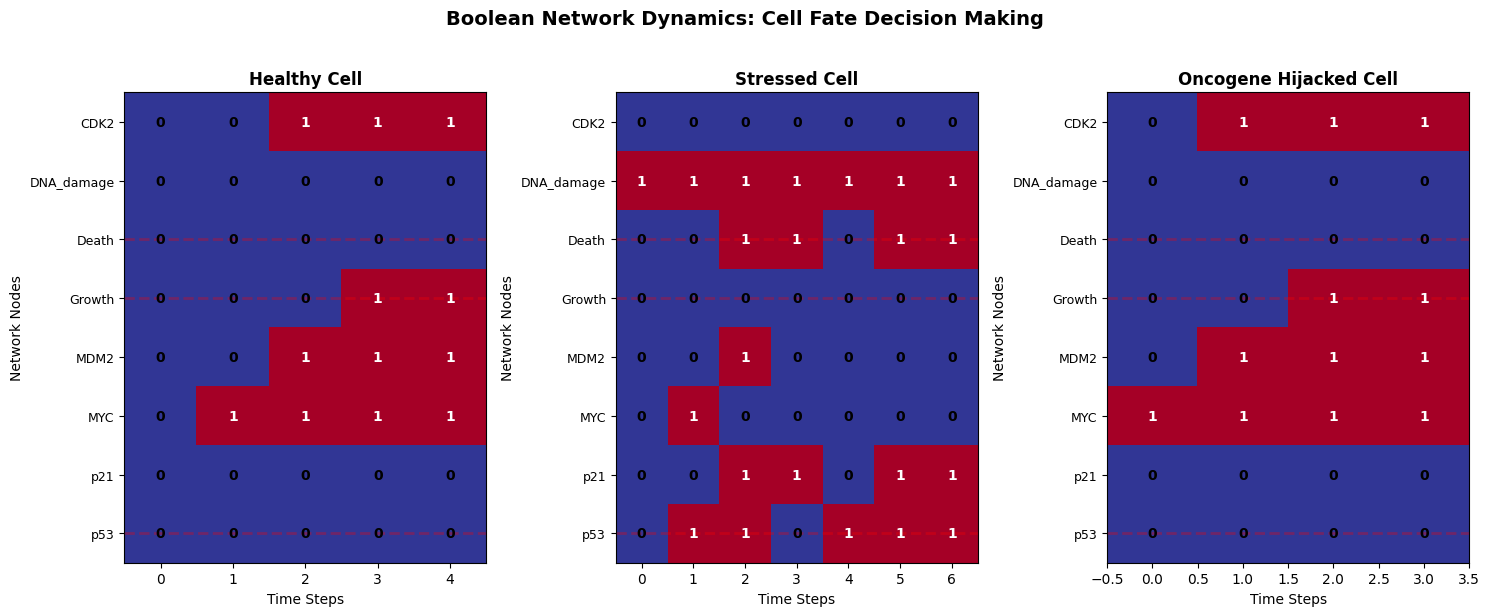

In [7]:
# 🟢 Visualize results
n_scenarios = len(results)
fig, axes = plt.subplots(1, n_scenarios, figsize=(5*n_scenarios, 6))

if n_scenarios == 1:
    axes = [axes]

for scenario_idx, (scenario_name, trajectory) in enumerate(results.items()):
    ax = axes[scenario_idx]

    # Create heatmap
    trajectory_matrix = trajectory.T  # Transpose for proper orientation

    im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

    # Formatting
    ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Network Nodes', fontsize=10)
    ax.set_yticks(range(len(node_names)))
    ax.set_yticklabels(node_names, fontsize=9)

    # Add text annotations
    for t in range(trajectory.shape[0]):
        for n in range(len(node_names)):
            color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
            ax.text(t, n, int(trajectory_matrix[n, t]),
                   ha="center", va="center", color=color, fontweight='bold')

    # Highlight key output nodes
    output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
    for output_idx in output_indices:  # Changed variable name to avoid conflict
        ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

❓ **Question**: Were your predictions for each scenario correct?
1. Which scenario leads to cell growth? Healthy cell and oncogene hijacked cell
2. Which scenario leads to cell death? stressed cell
3. How does p53 affect MYC? p53 suppresses MYC 
4. What happens when there's no DNA damage? The cell grows and does not die.


---

## **Part 3: Attractor analysis**

Attractors = stable states the network eventually reaches from any starting point

Types:
* Fixed Point: Network stops changing (steady state)
* Limit Cycle: Network oscillates in repeating pattern  

Why is this important?
* Represent system's natural 'destinations'
* Can predict long-term behavior
* Identify stable patterns in system
* Design interventions to reach desired attractors

In [8]:
import itertools

In [9]:
# 🟡 Let's find the attractor states

attractors = []
max_steps=15
node_names = sorted(network.nodes.keys())
n_nodes = len(node_names)

print(f"Testing all {2**n_nodes} possible initial states...")

# TODO: Generate all possible initial states
# Hint: Use itertools.product([0, 1], repeat=n_nodes)
all_states = list(itertools.product([0, 1], repeat=n_nodes))

for initial_state in all_states:
  # Set the network to this initial state
  state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
  network.set_state(**state_dict)

  # TODO: Simulate the network
  trajectory = network.simulate(steps=max_steps)

  # Check if it reached a steady state (last two states are the same)
  if len(trajectory) >= 2:
    final_state = tuple(trajectory[-1])  # Convert to tuple for comparison

  # Check if this is a new attractor
    if np.array_equal(trajectory[-1], trajectory[-2]):  # Steady state reached
      if final_state not in attractors:
        attractors.append(final_state)

Testing all 256 possible initial states...
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reac

❓ **Questions and interpretation**
1. How many total states did we test? *256*
2. Why does the number of states grow so quickly? *The growth is exponential because each additional node doubles the number of possible states. Thus: 2 ^ n. where n is the amount of nodes.*
3. What would happen if we had 15 nodes instead of 8? *Then we would have 2 ^ 15 = 32768 possible states.*
---


FOUND 3 ATTRACTORS:

Attractor 1: [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Normal growth

Attractor 2: [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → Death

Attractor 3: [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Growth despite DNA damage


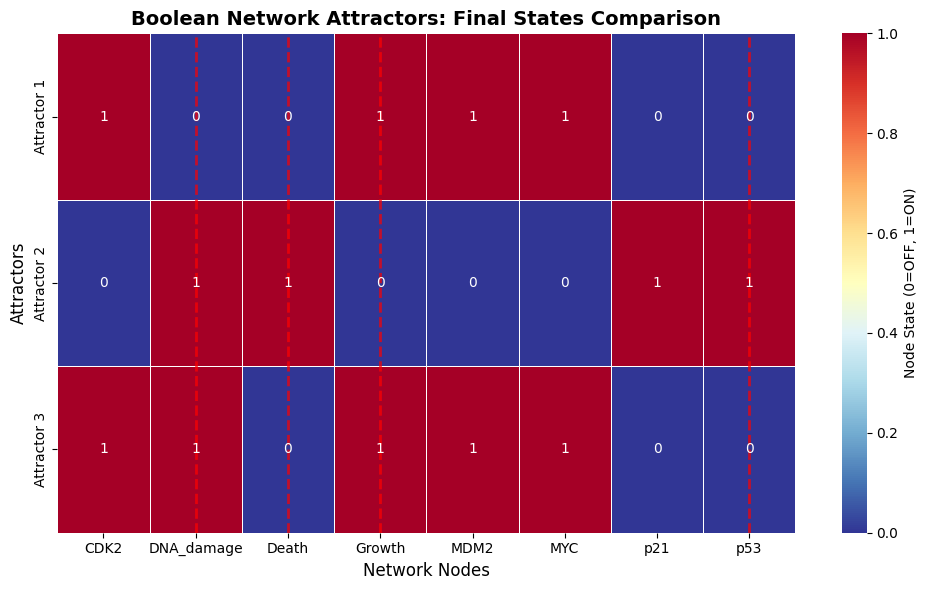

In [10]:
# 🟡 Let's find the attractor states

print(f"\nFOUND {len(attractors)} ATTRACTORS:")

for i, attractor in enumerate(attractors):
        print(f"\nAttractor {i+1}: {list(attractor)}")

        # Create state dictionary for easy access
        state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

        # Analyze the biological meaning
        growth_active = state_dict['Growth'] == 1
        death_active = state_dict['Death'] == 1
        p53_active = state_dict['p53'] == 1
        dna_damage_active = state_dict['DNA_damage'] == 1


        print(f"   Growth: {'ON' if growth_active else 'OFF'}")
        print(f"   Death: {'ON' if death_active else 'OFF'}")
        print(f"   p53: {'ON' if p53_active else 'OFF'}")
        print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

        # TODO: Interpret the meaning
        if growth_active and not death_active and not dna_damage_active:
            interpretation = "Normal growth"
        elif death_active and not growth_active:
            interpretation = "Death"
        elif growth_active and not death_active and dna_damage_active:
            interpretation = "Growth despite DNA damage"
        else:
            interpretation = "CONFLICT - Unusual state"

        print(f"   → {interpretation}")


# Convert attractors to clean matrix
attractor_matrix = []
for attractor in attractors:
    clean_row = [int(x) for x in attractor]
    attractor_matrix.append(clean_row)

attractor_matrix = np.array(attractor_matrix)

# Create heatmap
plt.figure(figsize=(10, max(6, len(attractors))))

# Create heatmap with custom colors
ax = sns.heatmap(attractor_matrix,
                 xticklabels=node_names,
                 yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                 cmap='RdYlBu_r',
                 cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                 annot=True,
                 fmt='d',
                 linewidths=0.5)

plt.title('Boolean Network Attractors: Final States Comparison',
          fontsize=14, fontweight='bold')
plt.xlabel('Network Nodes', fontsize=12)
plt.ylabel('Attractors', fontsize=12)

# Highlight key output nodes
output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
for node in output_nodes:
    if node in node_names:
        idx = node_names.index(node)
        ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

plt.tight_layout()
plt.show()

❓ **Questions and interpretation**
1. How many attractors did we find? *3*
2. What does each attractor represent biologically? *1: Normal growth. 2: Cell death. 3: Growth despite DNA damage.*
3. Which attractor represents a 'healthy' cell state and which one a 'cancerous' cell state? *'Healthy' cell state: attractor 1. 'Cancerous' cell state: attractor 3.



---





Analyzing 256 initial states...
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady 

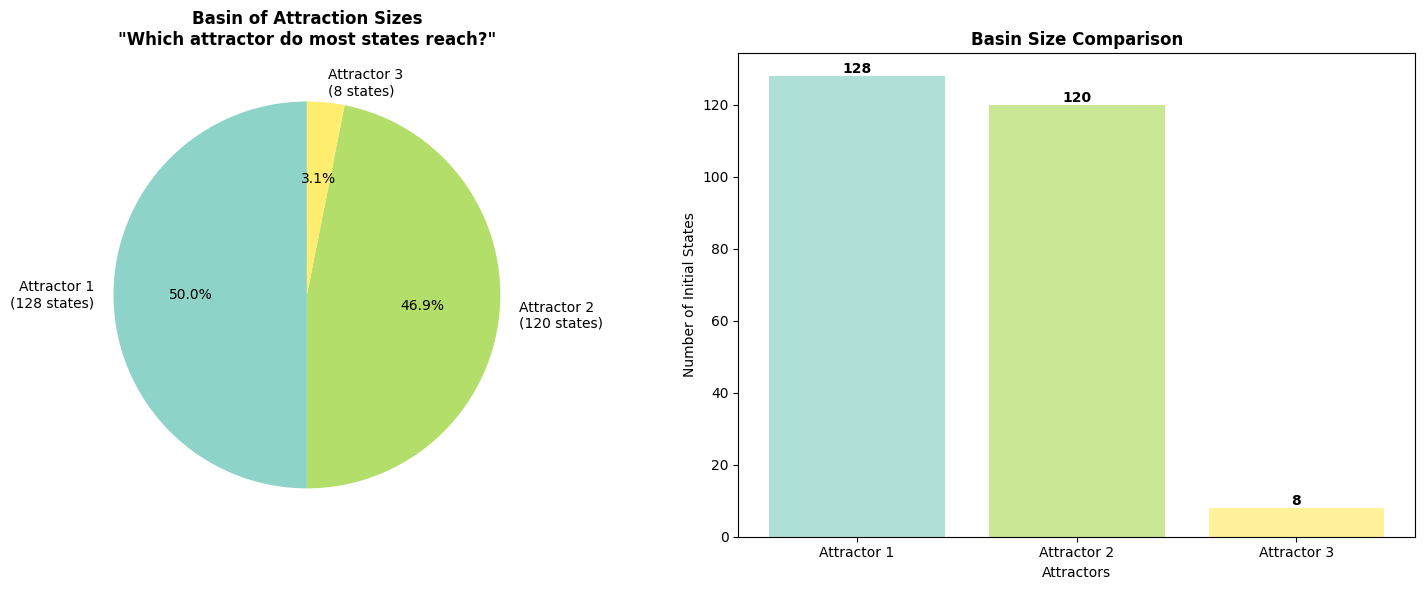

In [11]:
# 🟡 Which states end up in which attractor?

# Track which initial states lead to which attractors
basin_data = defaultdict(list)  # attractor -> list of initial states
attractor_map = {}  # initial_state -> attractor_index

n_nodes = len(node_names)
all_states = list(product([0, 1], repeat=n_nodes))
print(f"Analyzing {len(all_states)} initial states...")

for initial_state in all_states:
    # Set network state
    state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
    network.set_state(**state_dict)

    # Simulate
    trajectory = network.simulate(steps=max_steps, record_history=True)

    # Find which attractor this leads to
    if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
        final_state = tuple(int(x) for x in trajectory[-1])  # Clean conversion

        # Find matching attractor
        for att_idx, attractor in enumerate(attractors):
            clean_attractor = tuple(int(x) for x in attractor)
            if final_state == clean_attractor:
                basin_data[att_idx].append(initial_state)
                attractor_map[initial_state] = att_idx
                break

# Display basin sizes
print(f"\n Basin Sizes:")
total_states = len(all_states)
for att_idx in range(len(attractors)):
    basin_size = len(basin_data[att_idx])
    percentage = (basin_size / total_states) * 100
    print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")

# Create pie chart of basin sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of basin sizes
basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))

wedges, texts, autotexts = ax1.pie(basin_sizes,
                                   labels=basin_labels,
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   startangle=90)

ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"',
              fontsize=12, fontweight='bold')

# Bar chart comparison
attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)

ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Initial States', fontsize=10)
ax2.set_xlabel('Attractors', fontsize=10)

# Add value labels on bars
for bar, size in zip(bars, basin_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

❓ **Questions and interpretation**
* How many initial states lead to each attractor? <br>
   Attractor 1: 128 states ( 50.0%)<br>
   Attractor 2: 120 states ( 46.9%)<br>
   Attractor 3:   8 states (  3.1%)<br>

* Which attractors are most "popular" (large basins)?<br>
   Attractor 1 and 2





# Assignment 3

## Creating the networks

First we create the normal cell regulatory network and 4 different mutated versions of the normal network by modifying the Boolean rules.

### Normal network

In [12]:
# Normal regulatory network
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
normal_network = BooleanNetwork(nodes)

# Define Boolean rules (based on real biology, simplified)
normal_network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
normal_network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
normal_network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
normal_network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
normal_network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
normal_network.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
normal_network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
normal_network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

print("Rules:")
for node, rule_info in normal_network.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


### Mutation A: p53 Knockout (Loss of tumor suppressor)

In [13]:
mutation_A_network = BooleanNetwork(nodes)

# Add Boolean rules of normal network
for node, rule_info in normal_network.rules.items():
    mutation_A_network.add_rule(node, rule_info['function'], rule_info['description'])

# Add mutation rule
mutation_A_network.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)")

# Print rules 
print("Rules:")
for node, rule_info in mutation_A_network.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = BROKEN (always OFF)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


### Mutation B: MYC Amplification (Oncogene overexpression)

In [14]:
mutation_B_network = BooleanNetwork(nodes)

# Add Boolean rules of normal network
for node, rule_info in normal_network.rules.items():
    mutation_B_network.add_rule(node, rule_info['function'], rule_info['description'])

# Add mutation rule
mutation_B_network.add_rule('MYC', lambda s: True, "MYC = AMPLIFIED (always ON)")

# Print rules 
print("Rules:")
for node, rule_info in mutation_B_network.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = AMPLIFIED (always ON)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


### Mutation C:  MDM2 Overexpression (p53 pathway disruption)

In [15]:
mutation_C_network = BooleanNetwork(nodes)

# Add Boolean rules of normal network
for node, rule_info in normal_network.rules.items():
    mutation_C_network.add_rule(node, rule_info['function'], rule_info['description'])

# Add mutation rule
mutation_C_network.add_rule('MDM2', lambda s: True, "MDM2 = OVEREXPRESSED (always ON)")

# Print rules 
print("Rules:")
for node, rule_info in mutation_C_network.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = OVEREXPRESSED (always ON)
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


### Mutation D (Own choice): CDK2 Inactive

In [16]:
mutation_D_network = BooleanNetwork(nodes)

# Add Boolean rules of normal network
for node, rule_info in normal_network.rules.items():
    mutation_D_network.add_rule(node, rule_info['function'], rule_info['description'])

# Add mutation rule
mutation_D_network.add_rule('CDK2', lambda s: False, "CDK2 = INACTIVE (always OFF)")

# Print rules 
print("Rules:")
for node, rule_info in mutation_D_network.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = INACTIVE (always OFF)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


In [17]:
# Dictionary of all networks
networks = {
    'Normal': normal_network,
    'Mutation A': mutation_A_network,
    'Mutation B': mutation_B_network,
    'Mutation C': mutation_C_network,
    'Mutation D': mutation_D_network
}    

## Scenario Analysis

Scenarios from the practical:
*   Healthy Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Stressed Cell (Repairable): `{'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0,'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Oncogene Hijacked Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`


In [18]:
scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

In [19]:
results = {}

print("Starting scenario analysis ...")
# Loop over all networks (each mutation (A, B, C, D) + normal network)
for network_name, network_object in networks.items():
    print(f"\n Analyzing scenario for network: {network_name}")
    results[network_name] = {}
    # Loop over all scenarios
    for scenario, initial_state in scenarios.items():
        network_object.set_state(**initial_state)
        trajectory = network_object.simulate(steps=8)
        results[network_name][scenario] = trajectory

        final_state = trajectory[-1]
        node_names = sorted(network_object.nodes.keys())
        final_dict = {node: final_state[i] for i, node in enumerate(node_names)}

        print(f"        {scenario}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")


Starting scenario analysis ...

 Analyzing scenario for network: Normal
   Reached steady state after 4 steps
        Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 6 steps
        Stressed Cell: Final state: Growth=0, Death=1, p53=1
   Reached steady state after 3 steps
        Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0

 Analyzing scenario for network: Mutation A
   Reached steady state after 4 steps
        Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 4 steps
        Stressed Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 3 steps
        Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0

 Analyzing scenario for network: Mutation B
   Reached steady state after 4 steps
        Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 7 steps
        Stressed Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 3

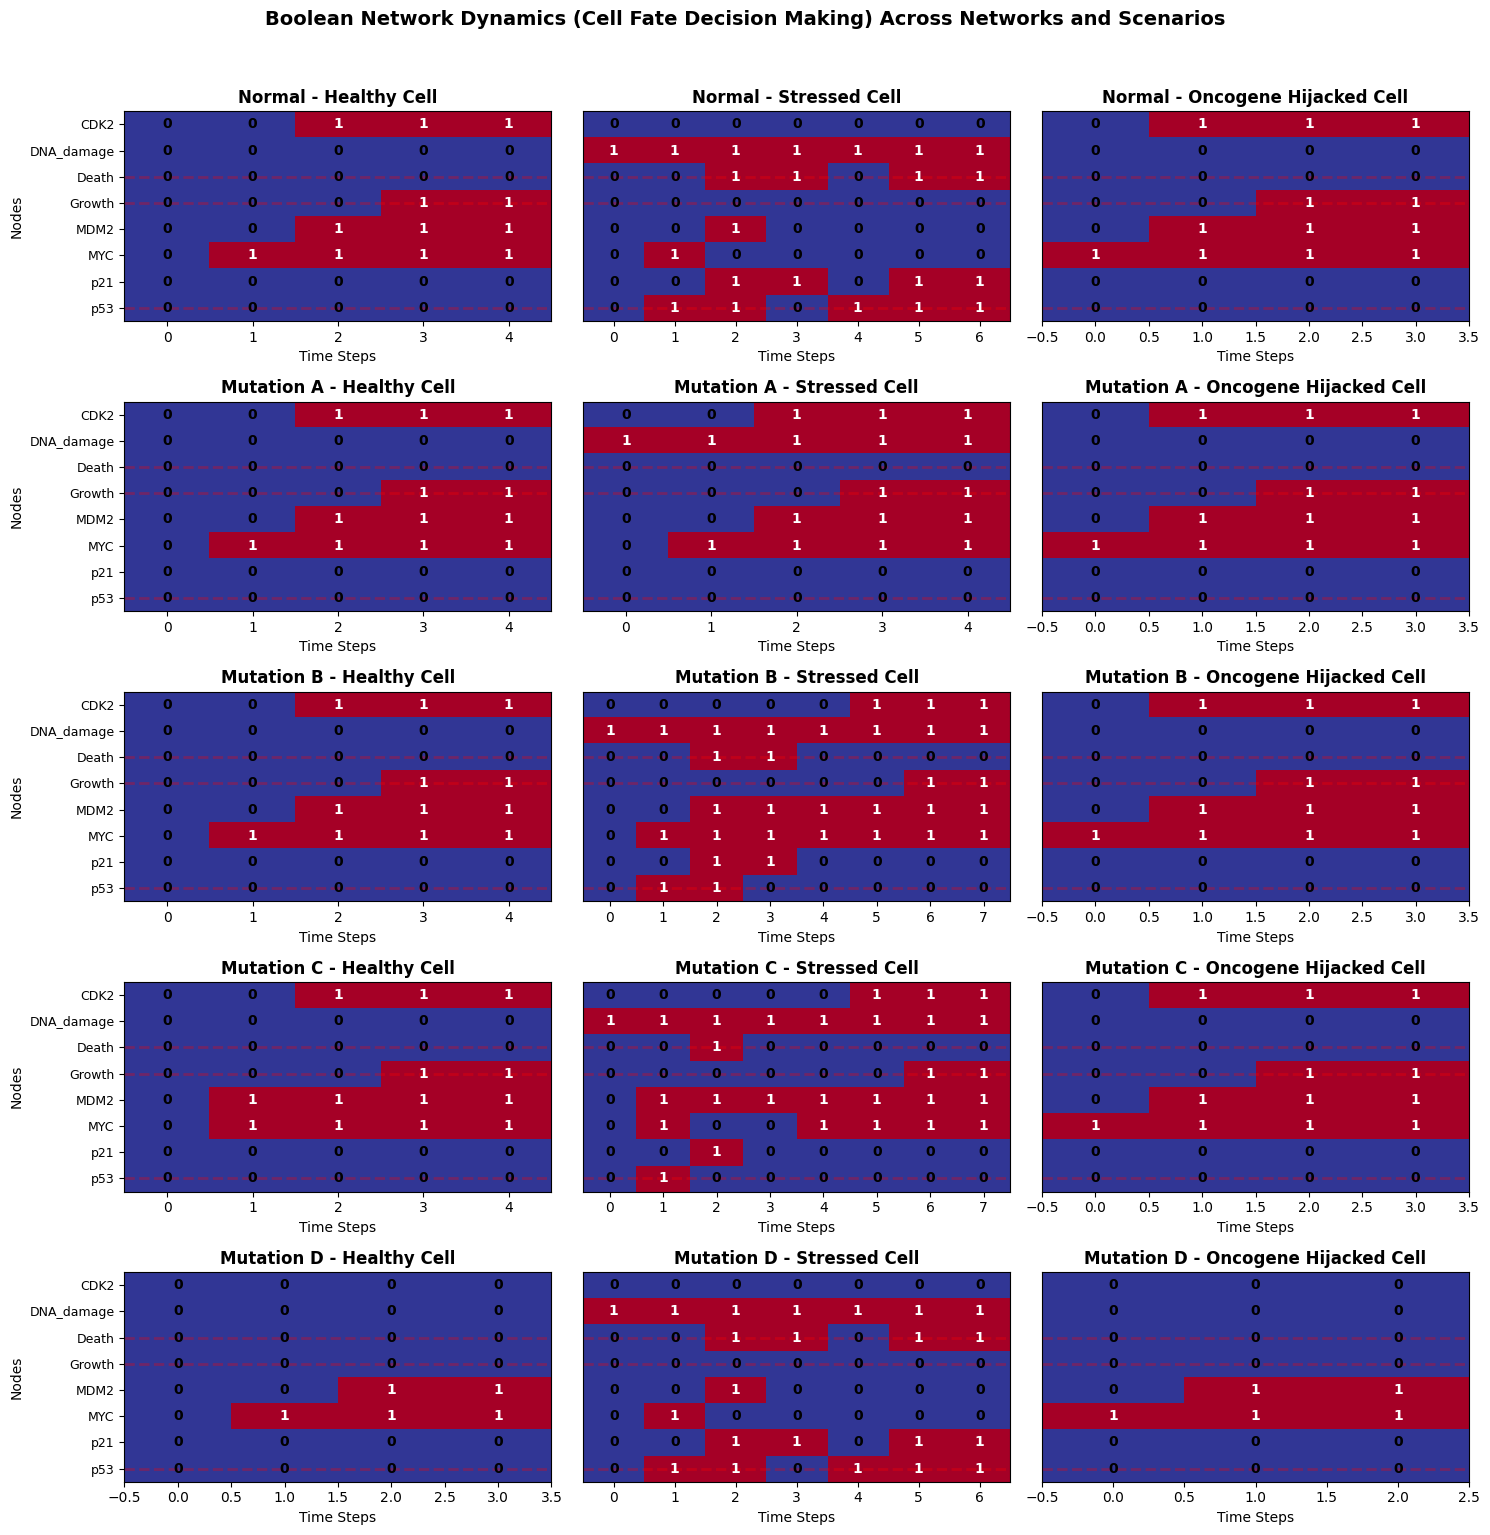

In [20]:
# Visualize results for all networks and scenarios
n_networks = len(results)
n_scenarios = len(next(iter(results.values())))  # number of scenarios per network

fig, axes = plt.subplots(n_networks, n_scenarios, figsize=(5*n_scenarios, 3*n_networks))

axes = np.atleast_2d(axes)  # ensures 2D grid no matter what

for row_idx, (network_name, scenario_dict) in enumerate(results.items()):
    for col_idx, (scenario_name, trajectory) in enumerate(scenario_dict.items()):
        ax = axes[row_idx, col_idx]

        # Create heatmap
        trajectory_matrix = trajectory.T  # Transpose for proper orientation

        im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

        # Formatting
        ax.set_title(f'{network_name} - {scenario_name}', fontweight='bold', fontsize=12)
        ax.set_xlabel('Time Steps', fontsize=10)
        if col_idx == 0: # Only add labels to y axis if its the leftmost column
            ax.set_ylabel('Nodes', fontsize=10)
            ax.set_yticks(range(len(node_names)))
            ax.set_yticklabels(node_names, fontsize=9)
        else:
            ax.set_yticks([])

        # Add text annotations
        for t in range(trajectory.shape[0]):
            for n in range(len(node_names)):
                color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
                ax.text(t, n, int(trajectory_matrix[n, t]),
                        ha="center", va="center", color=color, fontweight='bold')

        # Highlight key output nodes
        output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
        for output_idx in output_indices:  # Changed variable name to avoid conflict
            ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics (Cell Fate Decision Making) Across Networks and Scenarios',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Attractor Analysis

We find all attractors for the normal and each mutated network and show the percentage of states that leads to cancer-like states.

In [21]:
import itertools

Starting attractor analysis ...

 Analyzing attractors for network: Normal
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached st

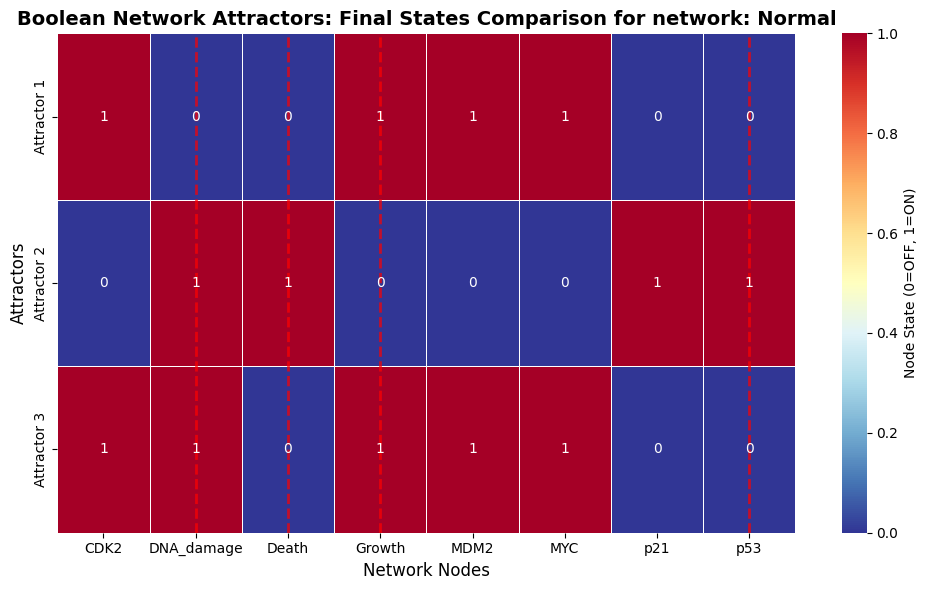


 Analyzing attractors for network: Mutation A
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   

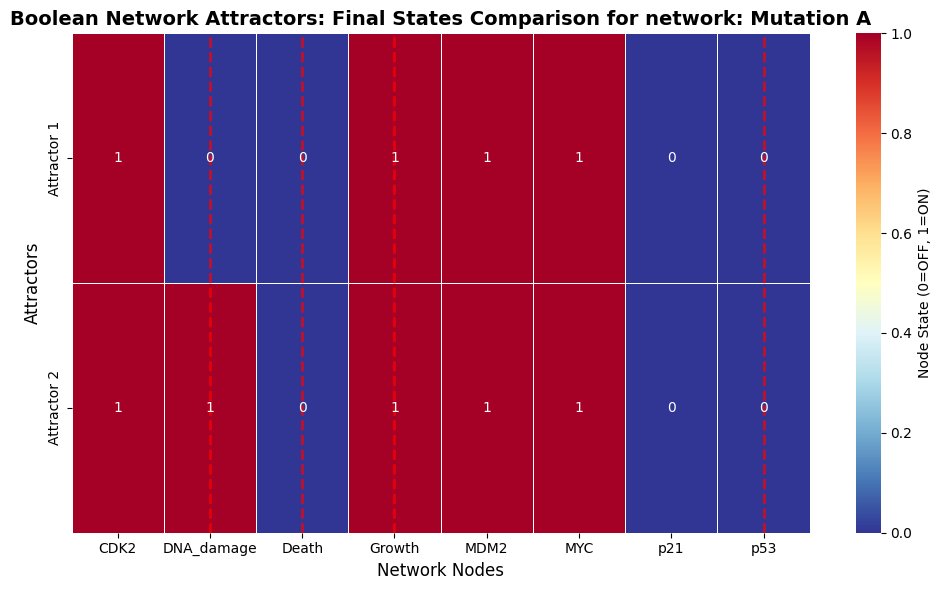


 Analyzing attractors for network: Mutation B
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   

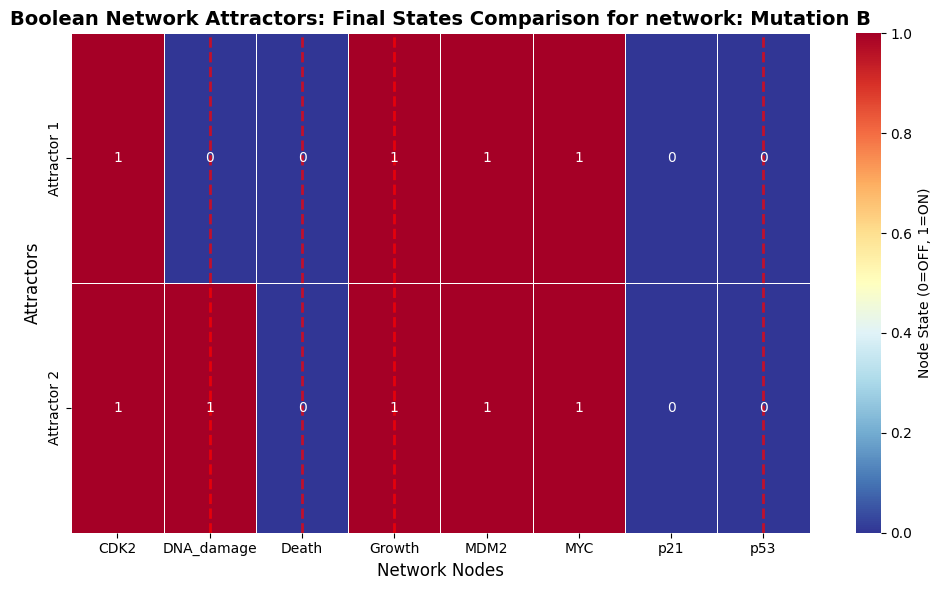


 Analyzing attractors for network: Mutation C
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   

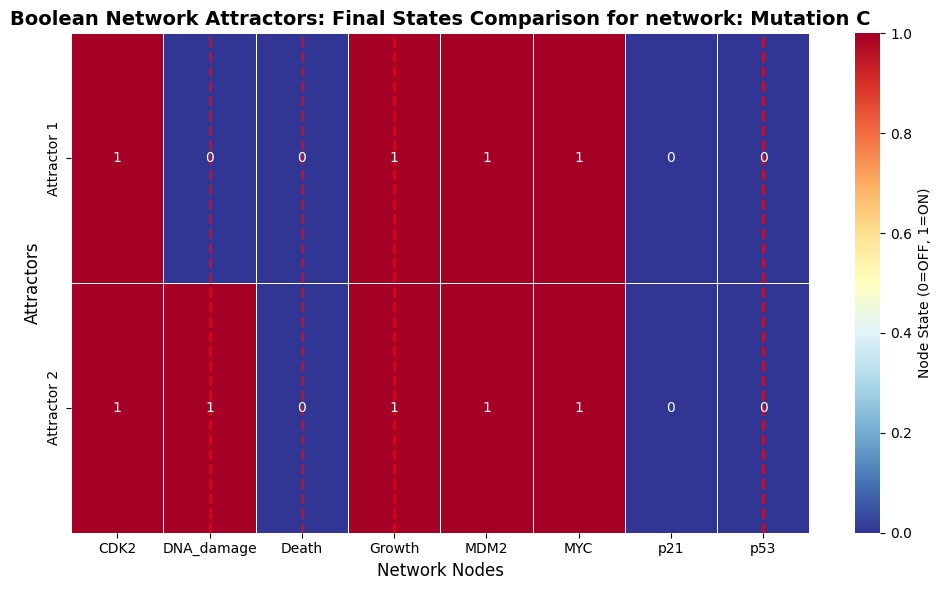


 Analyzing attractors for network: Mutation D
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 2 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 1 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 2 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   

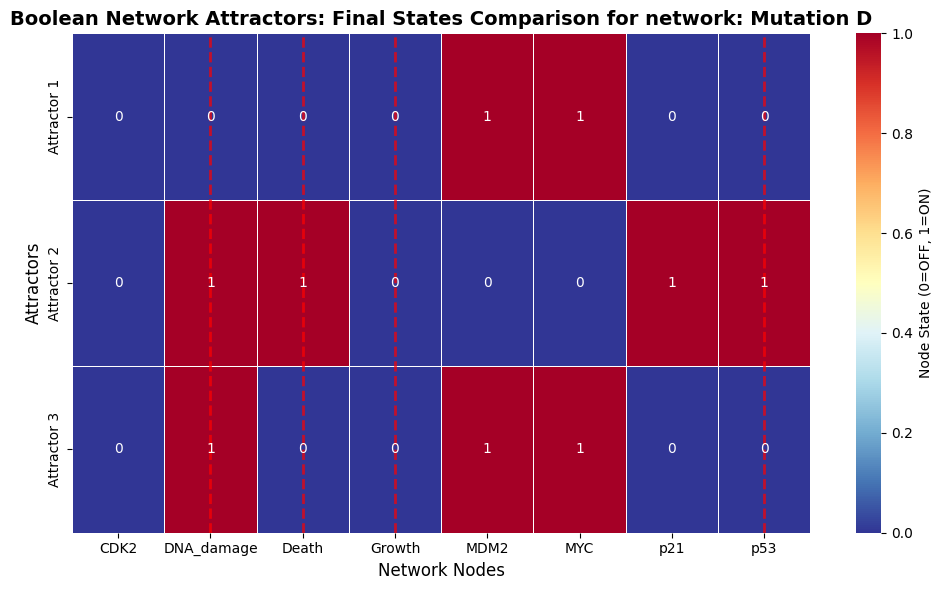

In [22]:
max_steps = 15

print("Starting attractor analysis ...")
for network_name, network_object in networks.items():
    print(f"\n Analyzing attractors for network: {network_name}")
    
    node_names = sorted(network_object.nodes.keys())
    n_nodes = len(node_names)
    
    # Generate all possible initial states
    all_states = list(itertools.product([0, 1], repeat=n_nodes))
    
    attractors = []
    basin_data = defaultdict(list)
    
    # Find all attractors
    for initial_state in all_states:
        # Set network state
        state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
        network_object.set_state(**state_dict)

        # Simulate
        trajectory = network_object.simulate(steps=max_steps, record_history=True)

        # Find which attractor this leads to
        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(int(x) for x in trajectory[-1]) # Clean conversion
             
            # Check if this is a new attractor
            if final_state not in attractors:
                attractors.append(final_state)

            # Find matching attractor
            for att_idx, attractor in enumerate(attractors):
                clean_attractor = tuple(int(x) for x in attractor)
                if final_state == clean_attractor:
                    basin_data[att_idx].append(initial_state)
                    # attractor_map[initial_state] = att_idx
                    break
    
    # Compute percentage of states leading to cancer-like states
    # We have a cancer-like state if growth is active, the cell is not death, and there is DNA damage
    cancer_states = 0
    for att_idx, attractor in enumerate(attractors):
        state_dict = {node_names[i]: attractor[i] for i in range(n_nodes)}
        if state_dict['Growth'] == 1 and state_dict['Death'] == 0 and state_dict['DNA_damage'] == 1:
            cancer_states += len(basin_data[att_idx])
    
    cancer_percentage = (cancer_states / len(all_states)) * 100
    
    print(f"\n  Total attractors: {len(attractors)}")

    # Display basin sizes
    print(f"\n Basin Sizes:")
    total_states = len(all_states)
    for att_idx in range(len(attractors)):
        basin_size = len(basin_data[att_idx])
        percentage = (basin_size / total_states) * 100
        print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")
        
    print(f"  Percentage of states leading to cancer-like states: {cancer_percentage:.1f}%")

    # Convert attractors to clean matrix
    attractor_matrix = []
    for attractor in attractors:
        clean_row = [int(x) for x in attractor]
        attractor_matrix.append(clean_row)

    attractor_matrix = np.array(attractor_matrix)

    # Create heatmap
    plt.figure(figsize=(10, max(6, len(attractors))))

    # Create heatmap with custom colors
    ax = sns.heatmap(attractor_matrix,
                     xticklabels=node_names,
                     yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                     cmap='RdYlBu_r',
                     cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                     annot=True,
                     fmt='d',
                     linewidths=0.5)
    
    plt.title(f'Boolean Network Attractors: Final States Comparison for network: {network_name}', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Network Nodes', fontsize=12)
    plt.ylabel('Attractors', fontsize=12)

    # Highlight key output nodes
    output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
    for node in output_nodes:
        if node in node_names:
            idx = node_names.index(node)
            ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)
        
    plt.tight_layout()
    plt.show()